In [7]:
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import display, clear_output

In [209]:
v0           = 300    # velocity

# center of mass:
lambda_c = 0.01# 0.5

# Avoid neighbors
lambda_a= 2.5 # .3

# Avoid obstacles
lambda_a_obstacle = 3

# Match velocity
lambda_m = 2 # 0.5

# Radius: neighbor collisions
r_nc = .2     # 10

# Radius: obstacles
r_o = 100

# Radius: match vel / center of mass
R = 15         # 5*140

#eta          = 0.5      # random fluctuation in angle (in radians)
W             = 10000      # width of box
H            = 6000        #Height of box
Rsq          = R**2     # square of the interaction radius
dt           = 0.2      # time step
Nt           = 200       # number of time steps
N            = 400     # number of birds
M = 11 # no of obstacles
d=350

In [166]:
def initialize_birds(N,W, H):
    '''
    Set initial positions, direction, and velocities
    '''
    # bird positions

    y = np.random.rand(N)*H/50 + 7*H/16
    x = np.random.uniform(0,1,N)*W/50

    # bird velocities
    theta =  0 * np.random.rand(N)
    vx = v0 * np.cos(theta)
    vy = v0 * np.sin(theta)

    return x, y, vx, vy, theta

In [3]:
def initialize_obstacles(M,W, H):
    x = np.random.rand(M)*W
    y = np.random.rand(M)*H

    return x,y

In [5]:
x_o, y_o = initialize_obstacles(M,W,H)

In [4]:
def perscribe_obstacles(M,W,H):

    x_pos = np.hstack((np.linspace(20,W,int(M/2)),np.linspace(20,W,int(M/2))))
    y_pos = np.hstack((np.ones(int(M/2))*H/3, np.ones(int(M/2))*2*H/3))

    x = np.hstack((np.hstack((x_pos,x_pos-1)), np.hstack((x_pos, x_pos))))
    y = np.hstack((np.hstack((y_pos, y_pos)), np.hstack((y_pos+1, y_pos-1))))

    return x,y

In [7]:
x_o, y_o = perscribe_obstacles(10,W,H)

In [201]:
def initialize_obstacles_grid(M,d, W, H):
    x_obs=[]
    y_obs=[]

    for i in range(M):
        for j in range(M):
            x_obs.append(d*i-(M-1)*d/2)
            y_obs.append(d*j-(M-1)*d/2)

    x_obs = np.array(x_obs)+W/2
    y_obs=np.array(y_obs) + H/2

    return x_obs, y_obs

In [169]:
def initialize_obstacles_triangle(M,d,W,H):
    x_obs = []
    y_obs = []

    for i in range(M+1):
        for j in range(i):
            x_obs.append(d*(np.sqrt(3)/2)*i)
            y_obs.append(d*(j - i/2 + 1/2))

    x_obs = np.array(x_obs) - d * M * np.sqrt(3) / 4 + W / 2
    y_obs = np.array(y_obs) + H / 2

    return x_obs, y_obs

In [139]:
def initialize_obstacles_diamond(M, d, W, H):
    x_obs=[]
    y_obs=[]
    
    for i in range(M):
        for j in range(M):
            y_obs.append(d * (M-1) * np.sqrt(2)/2
                       - d * j * np.sqrt(2) / 2 
                       - d * i * np.sqrt(2) / 2 )
            x_obs.append(d * j * np.sqrt(2) / 2 
                       - d * i * np.sqrt(2) / 2 ) 
    x_obs=np.array(x_obs)+W/2
    y_obs=np.array(y_obs)+H/2
    
    return x_obs, y_obs
        

In [9]:
def dead_bird(x,y,x_o, y_o):

    k = 0
    for bird in range(N):
        croppers = (x_o-x[bird])**2+(y_o-y[bird])**2 < 1
        k += sum(croppers)

    return k

In [10]:
def apply_boundary_conditions(x,y,W, H):
    '''
    Apply periodic boundary conditions
    '''
    #x = x % W
    #y = y % H
    return x, y

In [11]:
def update_positions(x, y,xv, vy, dt, W, H):
    '''
    Update the positions moving dt in the direction of the velocity
    and applying the boundary conditions
    '''

    # update positions
    x += vx*dt
    y += vy*dt

    # apply boundary conditions
    x, y = apply_boundary_conditions(x,y,W,H)
    return x, y

In [12]:
def COM(x,y):
    xc = 1/N*sum(x)
    yc = 1/N*sum(y)

    return xc, yc

In [162]:
def variance(x,y):
    
    # Combine x and y coordinates into a single 2D array
    points = np.vstack((x, y)).T

    # Calculate the centroid
    centroid = np.mean(points, axis=0)

    # Calculate the squared distances from the centroid
    squared_distances = np.sum((points - centroid) ** 2, axis=1)

    # Calculate the variance
    return np.sqrt(np.mean(squared_distances))

In [14]:
def centre_of_mass(x, x_boundary, y, y_boundary, lambda_c, R):
    # define neighbours birds can see

    vx_c=np.zeros_like(x)
    vy_c=np.zeros_like(y)

    for bird in range(N):
        neighbors = ((x-x[bird])**2+(y-y[bird])**2) < R**2 # find neighbours x_j within R
        boundary_neighbors = ((x_boundary - x[bird])**2 + (y_boundary-y[bird])**2) < R**2


        Ni = sum(neighbors) + sum(boundary_neighbors)
        sumx= np.sum(x[neighbors]) + np.sum(x[boundary_neighbors])
        sumy= np.sum(y[neighbors]) + np.sum(y[boundary_neighbors])

        vx_c[bird] = lambda_c*(sumx/Ni-x[bird])
        vy_c[bird] = lambda_c*(sumy/Ni-y[bird])

    return vx_c, vy_c

In [15]:
def avoid_collisions_birds(x, x_boundary, y, y_boundary, lambda_a, r_nc):
    # define birds within minimum distance

    vx_a=np.zeros_like(x)
    vy_a=np.zeros_like(x)

    for bird in range(N):
        neighbors = ((x-x[bird])**2+(y-y[bird])**2) < r_nc**2 # find neighbours x_j within r_n
        boundary_neighbors = ((x_boundary - x[bird])**2 + (y_boundary - y[bird])**2) <  r_nc**2


        vx_a[bird] = lambda_a*(np.sum(x[bird]-x[neighbors]) + np.sum(x[bird] - x_boundary[boundary_neighbors])) # -np.sum(x[boundary_neighbors]))
        vy_a[bird] = lambda_a*(np.sum(y[bird]-y[neighbors]) + np.sum(y[bird] - y_boundary[boundary_neighbors]))

    return vx_a, vy_a

In [16]:
def avoid_collisions_obstacle(x, y, x_o, y_o, lambda_a_obstacle, r_o):

    vx_a=np.zeros_like(x)
    vy_a=np.zeros_like(x)

    for birds in range(N):
        collisions = ((x_o-x[birds])**2+(y_o-y[birds])**2) < r_o**2 # find obstacles x_j within r_o


        vx_a[birds] = lambda_a_obstacle*(np.sum(x[birds]-x_o[collisions])) # -np.sum(x_o[boundary_collision]))
        vy_a[birds] = lambda_a_obstacle*(np.sum(y[birds]-y_o[collisions])) # -np.sum(y_o[boundary_collision]))


    return vx_a, vy_a

In [17]:
def match_velocities(x, x_boundary, y, y_boundary, vx, vy, lambda_m, R):

    vx_m=np.zeros_like(x)
    vy_m=np.zeros_like(x)

    for bird in range(N):
        neighbors = (x-x[bird])**2+(y-y[bird])**2 < R**2 # find neighbours x_j within R
        boundary_neighbors = (x_boundary - x[bird])**2 + (y_boundary - y[bird])**2 < R**2


        Ni = sum(neighbors) + sum(boundary_neighbors)  # + sum(boundary_neighbors)

        sumx= np.sum(vx[neighbors]) + np.sum(vx[boundary_neighbors])
        sumy= np.sum(vy[neighbors]) + np.sum(vy[boundary_neighbors])

        vx_m[bird] = lambda_m*(sumx / Ni - vx[bird])
        vy_m[bird] = lambda_m*(sumy / Ni - vy[bird])

    return vx_m, vy_m

In [75]:
def update_velocities(vx,vy,x,y):
    '''
    Update the velocities given theta
    '''

    x_boundary = x.copy()
    x_boundary[x < W / 2] =  x[x < W / 2] + W
    x_boundary[x >= W / 2] = x[x >= W / 2] - W

    y_boundary = y.copy()
    y_boundary[y < H / 2] = y[y < H / 2] + H
    y_boundary[y >= H / 2] = y[y >= H / 2] - H

    vx_c, vy_c = centre_of_mass(x, x_boundary, y, y_boundary, lambda_c, R)
    vx_m, vy_m = match_velocities(x, x_boundary, y, y_boundary, vx, vy, lambda_m, R)
    vx_ab, vy_ab = avoid_collisions_birds(x, x_boundary, y, y_boundary, lambda_a, r_nc)

    vx_ao, vy_ao = avoid_collisions_obstacle(x,y,x_o, y_o, lambda_a_obstacle, r_o)

    vx = vx + vx_c + vx_m + vx_ab + vx_ao + 50              #   imposing a bias for the birds
    vy = vy + vy_c + vy_m + vy_ab + vy_ao

    return vx, vy

In [154]:
def limit_speed(vx, vy, v0):

    vx, vy = update_velocities(vx, vy, x, y)

    vx_next = np.zeros_like(x)
    vy_next = np.zeros_like(x)

    for i in range(N):
        vx_next[i] = min(1, v0/np.sqrt(vx[i]**2+vy[i]**2))*vx[i]
        vy_next[i] = min(1, v0/np.sqrt(vx[i]**2+vy[i]**2))*vy[i]

    # birds travel north to south, dominant wind is from the west, additional component in +ve y direction 16.6km/h
    # in m/s this is 4.5 m/s assume 5 timesteps is a second
    vy_next +=-4.5


    return vx_next, vy_next

In [20]:
def step(x,y,vx,vy,dt):
    '''
    Compute a step in the dynamics:
    - update the positions
    - compute the new velocities
    '''


    x,y = update_positions(x, y, vx, vy, dt, W, H)
    vx,vy = limit_speed(vx,vy,v0)
    return x, y, vx, vy

In [21]:
def update_quiver(q,x,y,vx,vy):
    '''
    Update a quiver with new position and velocity information
    This is only used for plotting
    '''
    q.set_offsets(np.column_stack([x,y]))
    q.set_UVC(vx,vy)
    return q

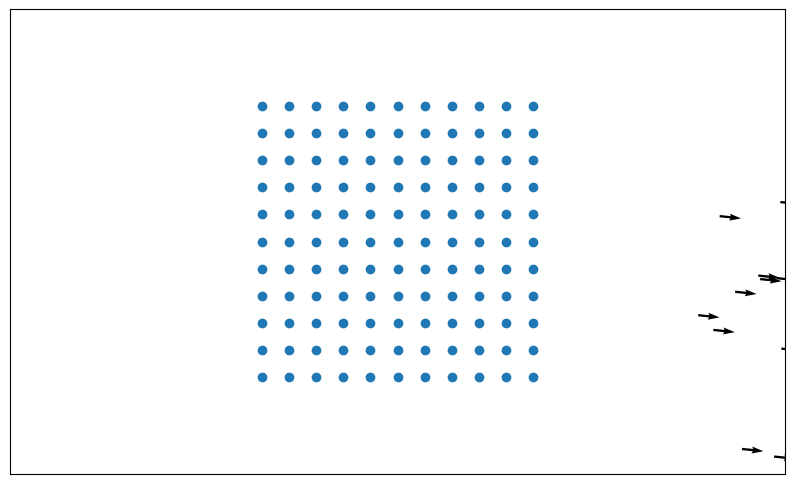

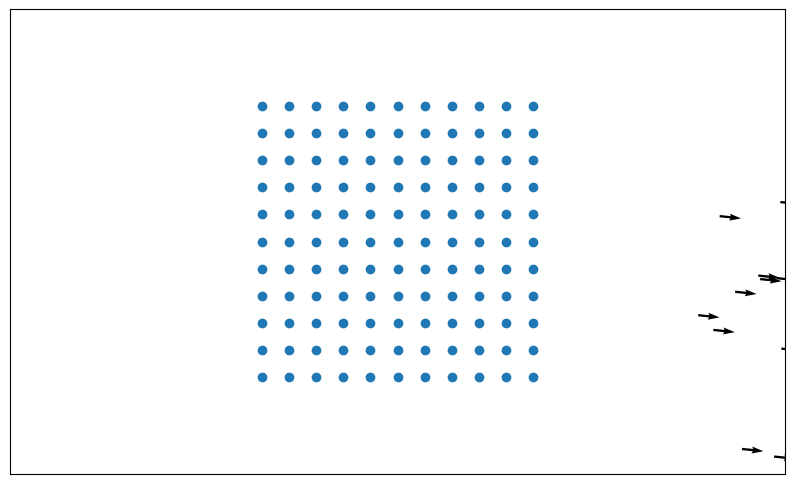

In [210]:
#x_o, y_o = initialize_obstacles_triangle(M,d,W,H)
#x_o, y_o = initialize_obstacles_diamond(M, d,W, H)
x_o, y_o = initialize_obstacles_grid(M, d,W, H)


# set up a figure
fig, ax = plt.subplots(figsize = (10,10))

# get the initial configuration
x, y, vx, vy, theta = initialize_birds(N,W,H)

# do an initial plot and set up the axes
q = plt.quiver(x,y,vx,vy)
ax.set(xlim=(0, W), ylim=(0, H))
ax.set_aspect('equal')
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)

k=0
plt.scatter(x_o, y_o)
xc, yc=COM(x,y)
xc_list, yc_list = [xc], [yc]
distance = [variance(x,y)/2]

# do each step, updating the quiver and plotting the new one
for iT in range(Nt):
    k += dead_bird(x,y,x_o,y_o)
    x,y,vx,vy = step(x,y,vx,vy,dt)
    xc_list.append(COM(x,y)[0])
    yc_list.append(COM(x,y)[1])
    distance.append(variance(x,y)/2)
    q = update_quiver(q,x,y,vx,vy)
    clear_output(wait=True)
    display(fig)
    #plt.savefig('flock.pdf')

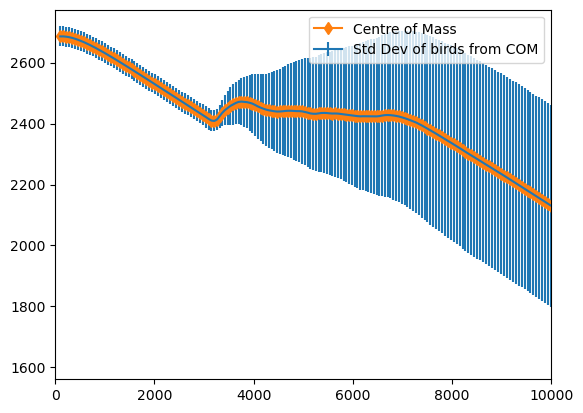

In [211]:

plt.errorbar(xc_list,yc_list, distance, label = 'Std Dev of birds from COM')
plt.plot(xc_list, yc_list, '-d', label='Centre of Mass')
plt.xlim(0,W)

plt.legend()

plt.show()

In [150]:
print('The number of birds who died (got too close to the obstacles) is '+str(k))

The number of birds who died (got too close to the obstacles) is 0
